In [3]:
import os
import json
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [4]:
f = open('metadata.json')
data = json.load(f)

#to extract upright rect coordinates for each image

data_prepr={}
for pool in data:
    x_list = []
    y_list = []
    for bounds in data[pool]['bounds_x_y']:
        x_list = x_list + [bounds['x']]
        y_list = y_list + [bounds['y']]
    geom = list(zip(x_list, y_list))
    mask = np.zeros((512,512,3), dtype="float32")
    polyg = np.array([list(x) for x in (np.array(geom))], dtype=np.int32 )
    data_prepr[pool] = {'rect': tuple(int(d/4) for d in cv2.boundingRect(np.array([list(x) for x in (np.array(geom))], np.float32))), 'polyg': cv2.cvtColor(cv2.fillConvexPoly(mask,polyg, color=(255,255,255)),cv2.COLOR_BGR2GRAY).astype('float32')}

In [5]:
#sorted list of images by name
image_name_list = [x.split("/")[-1] for x in sorted(glob("/Users/medhahegde/Documents/Sem 2/Advanced Analytics/images/*.png"))]

In [239]:
# #save masks locally
# for pool in image_name_list:
#     cv2.imwrite(PATH+'masks/{}'.format(pool), data_prepr[pool]['polyg'])
#     print(pool)

42.6339681_2.8641433.png
42.6342371_2.8637476.png
42.6342817_2.8647664.png
42.634614_2.8724463.png
42.6347619_2.8669355.png
42.6349433_2.8699028.png
42.6349664_2.8706975.png
42.6350102_2.8647506.png
42.6351374_2.8650873.png
42.6351392_2.8656068.png
42.6351629_2.8722023.png
42.6351969_2.8667526.png
42.6352225_2.865558.png
42.6352842_2.8648756.png
42.6353039_2.8672572.png
42.6353365_2.8705038.png
42.6353406_2.8654179.png
42.6358913_2.8727748.png
42.6361194_2.8725454.png
42.6362062_2.8719883.png
42.6362729_2.865704.png
42.6363236_2.8647969.png
42.6364736_2.866849.png
42.6365026_2.8691507.png
42.6365597_2.8725599.png
42.6366192_2.8721523.png
42.6367168_2.6882326.png
42.636763_2.8686717.png
42.6367944_2.8687137.png
42.637004_2.6891636.png
42.6371408_2.8691249.png
42.6371645_2.8699125.png
42.6371714_2.688133.png
42.637205_2.8694305.png
42.6372846_2.8636563.png
42.6373711_2.8636764.png
42.6374519_2.8631962.png
42.6375056_2.8726488.png
42.6375205_2.8753727.png
42.637546_2.689366.png
42.6377766

In [83]:
np.random.seed(42)
tf.random.set_seed(42)
IMAGE_SIZE = 128
EPOCHS = 10
BATCH = 4
LR = 0.001
PATH = "/Users/medhahegde/Documents/Sem 2/Advanced Analytics/"

In [84]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [85]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [86]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [87]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  11930
Validation data:  1491
Testing data:  1491


In [88]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

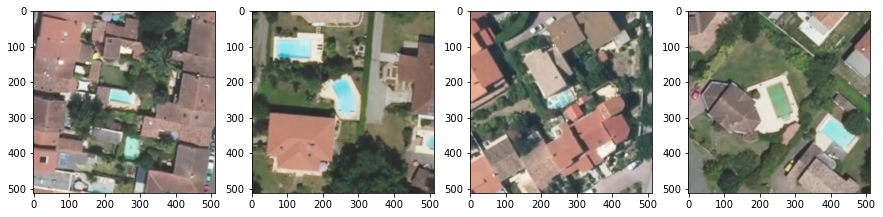

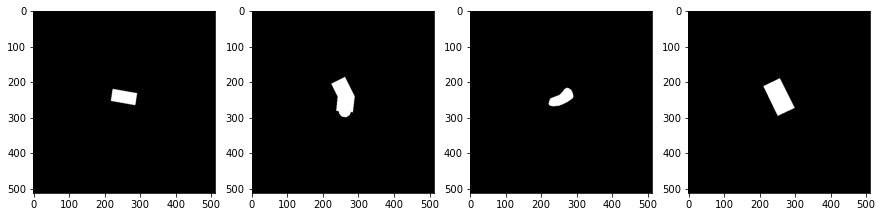

In [89]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [90]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")

    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [91]:
model = model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1[0][0]']         

In [92]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [93]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [94]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [95]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [96]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/10


2022-05-21 21:44:30.641914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2983/2983 [==============================] - ETA: 0s - loss: 0.2369 - dice_coef: 0.7631 - recall_4: 0.8380 - precision_4: 0.6298

2022-05-21 21:51:05.868724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2983/2983 [==============================] - 413s 131ms/step - loss: 0.2369 - dice_coef: 0.7631 - recall_4: 0.8380 - precision_4: 0.6298 - val_loss: 0.1778 - val_dice_coef: 0.8222 - val_recall_4: 0.9053 - val_precision_4: 0.7744 - lr: 0.0010
Epoch 2/10
2983/2983 [==============================] - 379s 127ms/step - loss: 0.1330 - dice_coef: 0.8670 - recall_4: 0.8411 - precision_4: 0.8940 - val_loss: 0.1588 - val_dice_coef: 0.8412 - val_recall_4: 0.9186 - val_precision_4: 0.7992 - lr: 0.0010
Epoch 3/10
2983/2983 [==============================] - 394s 132ms/step - loss: 0.1262 - dice_coef: 0.8738 - recall_4: 0.8479 - precision_4: 0.9000 - val_loss: 0.1382 - val_dice_coef: 0.8619 - val_recall_4: 0.8930 - val_precision_4: 0.8488 - lr: 0.0010
Epoch 4/10
2983/2983 [==============================] - 1003s 336ms/step - loss: 0.1220 - dice_coef: 0.8779 - recall_4: 0.8532 - precision_4: 0.9033 - val_loss: 0.1292 - val_dice_coef: 0.8709 - val_recall_4: 0.8701 - val_precision_4: 0.8817 - lr: 0.001

In [97]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

373/373 [==============================] - 15s 40ms/step - loss: 0.1230 - dice_coef: 0.8770 - recall_4: 0.8394 - precision_4: 0.9148


[0.12304575741291046,
 0.8769917488098145,
 0.8394309282302856,
 0.914832592010498]

In [98]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

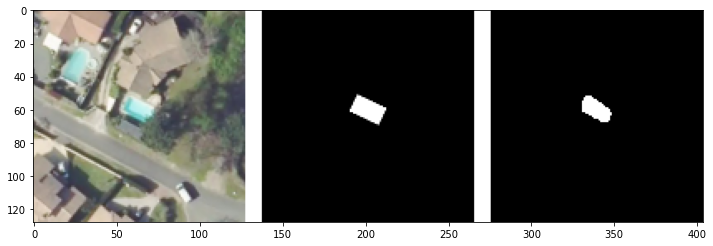

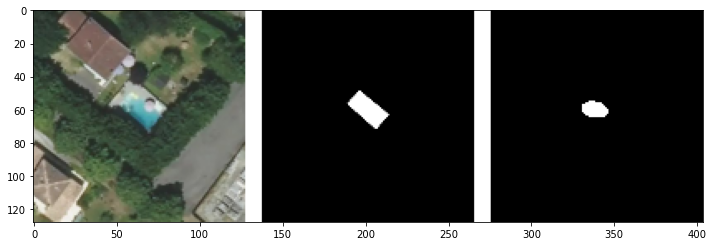

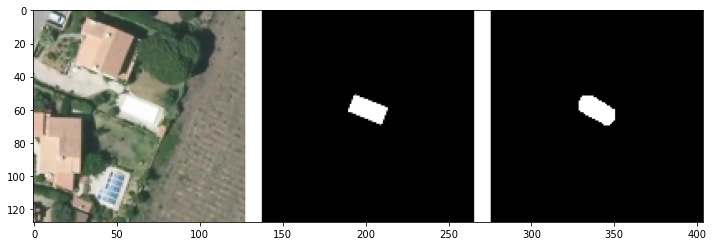

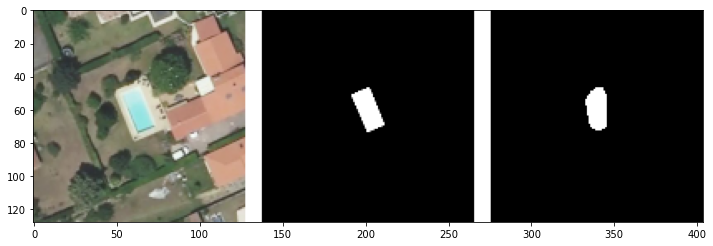

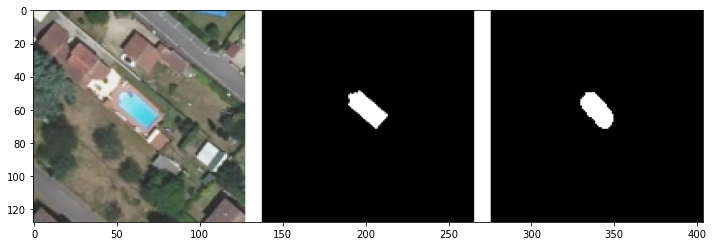

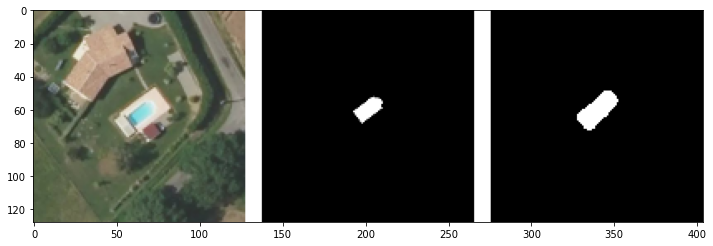

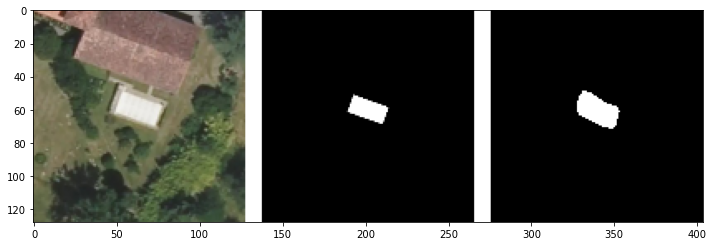

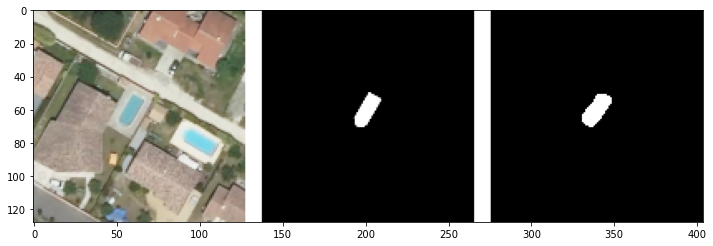

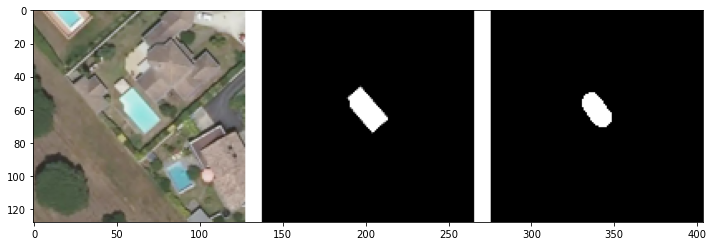

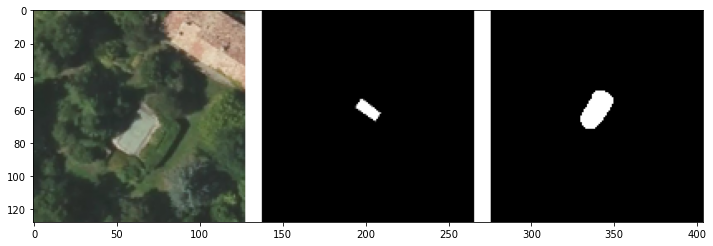

In [100]:
for i, (x, y) in enumerate(zip(test_x[0:10], test_y[0:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)